In [1]:
import os
os.chdir("/data/lodhar2/GSViT")
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from EfficientViT.classification.model.build import EfficientViT_M5

/home/lodhar2/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/lodhar2/.local/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
# ——————————————
# 1. channel-flip to match GSViT’s BGR convention
def process_inputs(images):
    tmp = images[:, 0, :, :].clone()
    images[:, 0, :, :] = images[:, 2, :, :]
    images[:, 2, :, :] = tmp
    return images

In [3]:
# ——————————————
# 2. Model wrapper with new head, filtering only the `evit.` keys
class GSViTWithHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # build backbone and strip its old classifier
        backbone_pre = EfficientViT_M5(pretrained=None)
        backbone = nn.Sequential(*list(backbone_pre.children())[:-1])

        # load checkpoint & keep only the "evit." entries
        ckpt = torch.load("GSViT.pkl", map_location="cpu")
        filtered = {
            k[len("evit."):]: v
            for k,v in ckpt.items()
            if k.startswith("evit.")
        }
        backbone.load_state_dict(filtered, strict=False)
        self.backbone = backbone

        # figure out feature‐dim on a dummy
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            feat = self.backbone(dummy)
            feat_dim = feat.view(1, -1).shape[1]

        # new classification head
        self.classifier = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        x = process_inputs(x)
        feats = self.backbone(x).view(x.size(0), -1)
        return self.classifier(feats)

In [4]:
# ——————————————
# 3. Dataset → yields (image_tensor, label_idx)
class HistologyDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root = root_dir
        self.transform = transform
        self.classes = sorted(self.df["Class"].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.root, row["img_path"])
        img  = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.class_to_idx[row["Class"]]
        return img, label

In [5]:
# ——————————————
def main():
    df = pd.read_csv("split_balanced_dataset.csv")
    train_df = df[df["split"]=="train"]
    val_df   = df[df["split"]=="val"]

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_loader = DataLoader(
        HistologyDataset(train_df, ".", transform),
        batch_size=16, shuffle=True,  num_workers=4
    )
    val_loader   = DataLoader(
        HistologyDataset(val_df,   ".", transform),
        batch_size=16, shuffle=False, num_workers=4
    )

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model  = GSViTWithHead(num_classes=len(train_df["Class"].unique())).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    for epoch in range(1, 11):
        # — train —
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss   = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch} train loss: {total_loss/len(train_loader):.4f}")

        # — validate —
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds  = model(imgs).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total   += labels.size(0)
        acc = correct/total
        print(f"Epoch {epoch} val  acc: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_gsvit.pth")
            print("saved new best model")

In [6]:
if __name__ == "__main__":
    main()

/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1 train loss: 11.5180
Epoch 1 val  acc: 0.2318
saved new best model
Epoch 2 train loss: 5.3893
Epoch 2 val  acc: 0.2273
Epoch 3 train loss: 4.7524
Epoch 3 val  acc: 0.1636
Epoch 4 train loss: 3.4818
Epoch 4 val  acc: 0.1909
Epoch 5 train loss: 2.3449
Epoch 5 val  acc: 0.1636
Epoch 6 train loss: 1.9042
Epoch 6 val  acc: 0.2273
Epoch 7 train loss: 1.8715
Epoch 7 val  acc: 0.2318
Epoch 8 train loss: 1.5296
Epoch 8 val  acc: 0.2000
Epoch 9 train loss: 0.9399
Epoch 9 val  acc: 0.2227
Epoch 10 train loss: 1.2243
Epoch 10 val  acc: 0.2818
saved new best model


# Eval

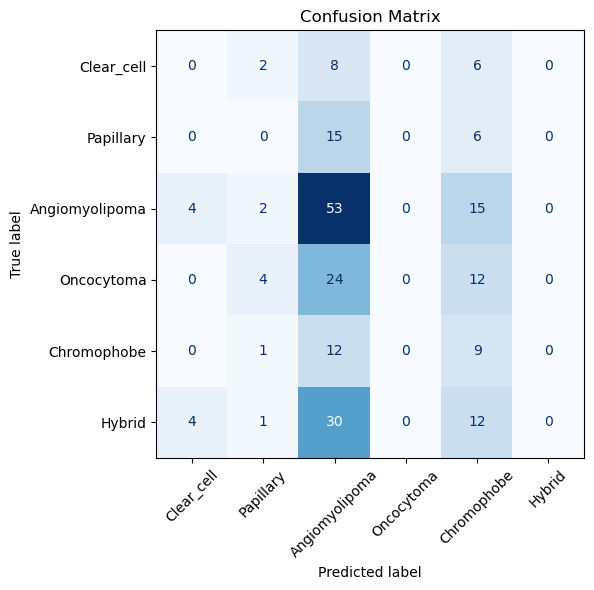

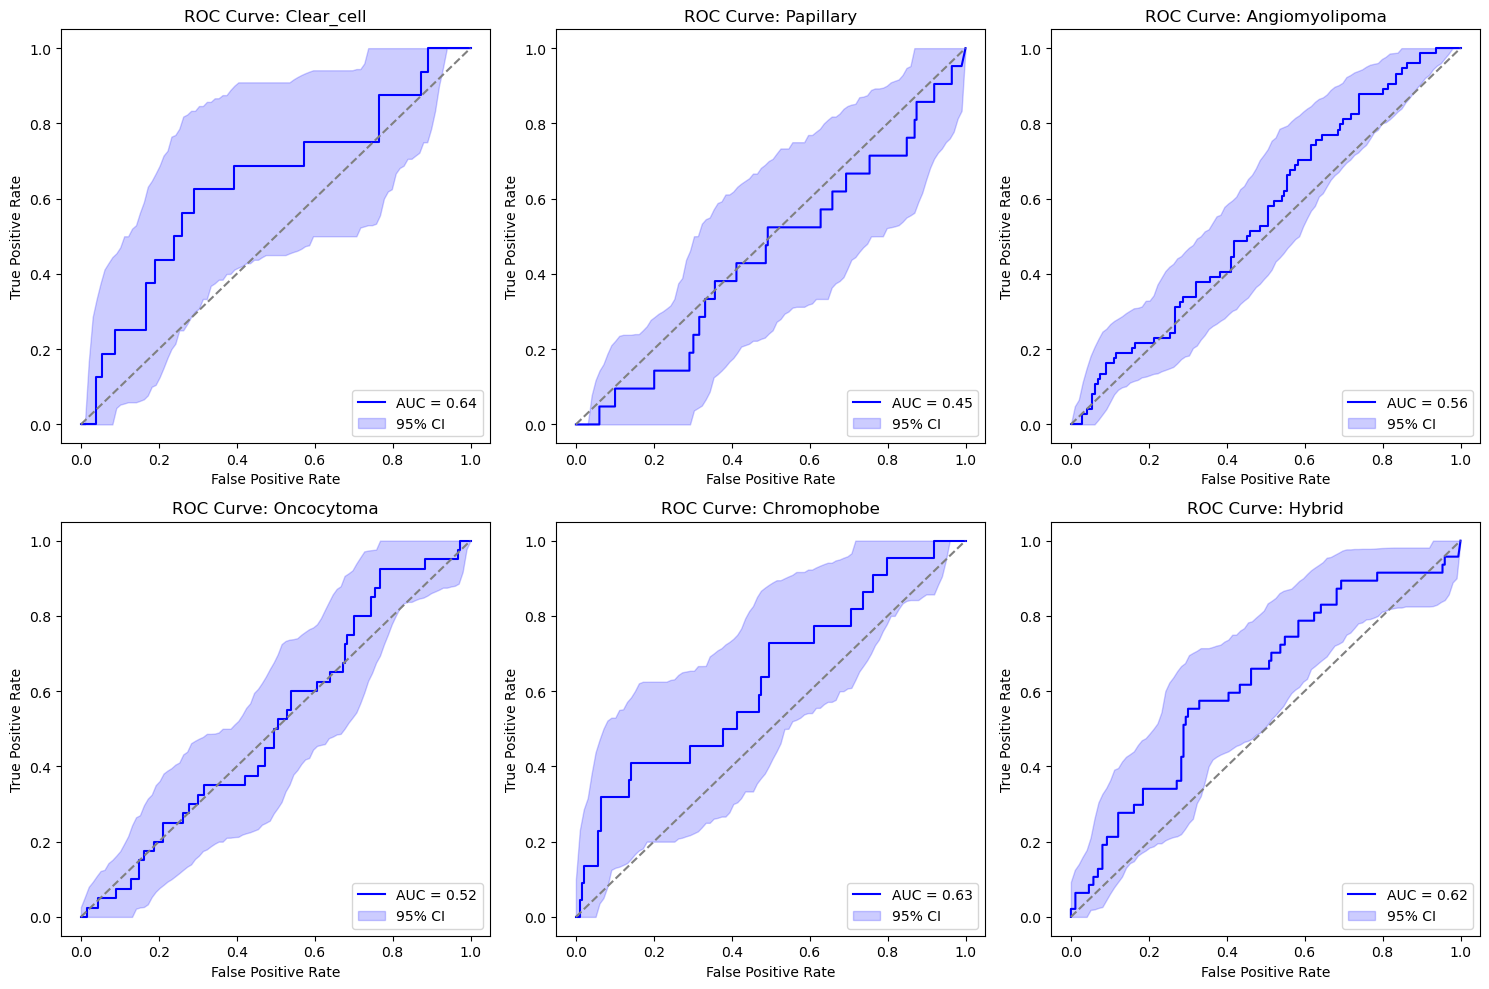

In [9]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score
)

from EfficientViT.classification.model.build import EfficientViT_M5

# ---------------------------
# === GSViT Model Wrapper ===
# ---------------------------
def process_inputs(images):
    tmp = images[:, 0, :, :].clone()
    images[:, 0, :, :] = images[:, 2, :, :]
    images[:, 2, :, :] = tmp
    return images

class GSViTWithHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone_pre = EfficientViT_M5(pretrained=None)
        backbone = nn.Sequential(*list(backbone_pre.children())[:-1])

        ckpt = torch.load("GSViT.pkl", map_location="cpu")
        filtered = {k[len("evit."):]: v for k, v in ckpt.items() if k.startswith("evit.")}
        backbone.load_state_dict(filtered, strict=False)
        self.backbone = backbone

        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            feat = self.backbone(dummy)
            feat_dim = feat.view(1, -1).shape[1]

        self.classifier = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        x = process_inputs(x)
        feats = self.backbone(x).view(x.size(0), -1)
        return self.classifier(feats)

# ----------------------
# === Dataset Loader ===
# ----------------------
class HistologyDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root = root_dir
        self.transform = transform
        self.classes = sorted(self.df["Class"].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.root, row["img_path"])
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.class_to_idx[row["Class"]]
        return img, label

# ------------------------
# === Evaluation Script ===
# ------------------------
def evaluate():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # === Load validation data ===
    df = pd.read_csv("split_balanced_dataset.csv")
    val_df = df[df["split"] == "val"]
    class_order = class_order = ['Clear_cell', 'Papillary', 'Angiomyolipoma', 'Oncocytoma', 'Chromophobe', 'Hybrid']
#sorted(val_df["Class"].unique())
    class_to_idx = {cls: i for i, cls in enumerate(class_order)}
    idx_to_class = {i: cls for cls, i in class_to_idx.items()}

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    val_loader = DataLoader(HistologyDataset(val_df, ".", transform), batch_size=16, shuffle=False, num_workers=2)

    # === Load model ===
    model = GSViTWithHead(num_classes=len(class_order)).to(device)
    model.load_state_dict(torch.load("best_gsvit.pth", map_location=device))
    model.eval()

    # === Predict on validation set ===
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_probs.append(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # === Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx_to_class[i] for i in range(len(class_order))])
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=False)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # === ROC AUC Plots ===
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()
    rng = np.random.RandomState(42)

    for i, cls in enumerate(class_order):
        idx = class_to_idx[cls]
        binary_labels = (all_labels == idx).astype(int)
        binary_probs = all_probs[:, idx]

        fpr, tpr, _ = roc_curve(binary_labels, binary_probs)
        roc_auc = auc(fpr, tpr)

        fpr_linspace = np.linspace(0, 1, 100)
        tpr_bootstrap = []

        for _ in range(1000):
            indices = rng.randint(0, len(binary_labels), len(binary_labels))
            if len(np.unique(binary_labels[indices])) < 2:
                continue
            fpr_b, tpr_b, _ = roc_curve(binary_labels[indices], binary_probs[indices])
            tpr_interp = np.interp(fpr_linspace, fpr_b, tpr_b)
            tpr_bootstrap.append(tpr_interp)

        tpr_bootstrap = np.array(tpr_bootstrap)
        tpr_lower = np.percentile(tpr_bootstrap, 2.5, axis=0)
        tpr_upper = np.percentile(tpr_bootstrap, 97.5, axis=0)

        axs[i].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="blue")
        axs[i].fill_between(fpr_linspace, tpr_lower, tpr_upper, color="blue", alpha=0.2, label="95% CI")
        axs[i].plot([0, 1], [0, 1], linestyle="--", color="gray")
        axs[i].set_title(f"ROC Curve: {cls}")
        axs[i].set_xlabel("False Positive Rate")
        axs[i].set_ylabel("True Positive Rate")
        axs[i].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate()
